In [1]:
import numpy as np
import datacube
from datacube.api import GridWorkflow
from madmex.wrappers import gwf_query
import fiona
import pprint
from madmex.io.vector_db import VectorDb, load_segmentation_from_dataset
from madmex.models import PredictObject
from madmex.models import PredictClassification, Tag, Region
from django.contrib.gis.geos import Polygon
from madmex.util import chunk
import json
from shapely.geometry import mapping
from madmex.util.spatial import geometry_transform
from shapely.geometry import shape
from shapely.ops import cascaded_union
from dask.distributed import Client

In [2]:
name_predict = 's2_fiona_predict'

In [3]:
pred_objects = PredictClassification.objects.filter(name=name_predict).prefetch_related('tag')

In [4]:
len(pred_objects)

20000

In [5]:
(pred_objects[0],pred_objects[1])

(<PredictClassification: PredictClassification object (20001)>,
 <PredictClassification: PredictClassification object (20002)>)

In [6]:
pred_objects.distinct('predict_object_id')

<QuerySet [<PredictClassification: PredictClassification object (30000)>, <PredictClassification: PredictClassification object (40000)>]>

In [7]:
qs_ids = pred_objects.distinct('predict_object_id')

In [8]:
qs_ids

<QuerySet [<PredictClassification: PredictClassification object (30000)>, <PredictClassification: PredictClassification object (40000)>]>

In [11]:
region = 'Jalisco'

In [12]:
region_geom = Region.objects.get(name=region).the_geom
region_geojson = region_geom.geojson
geometry = json.loads(region_geojson)
proj4='+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +a=6378137 +b=6378136.027241431 +units=m +no_defs'
geometry_proj = geometry_transform(geometry,proj4)

In [13]:
shape_Jalisco=shape(geometry_proj)

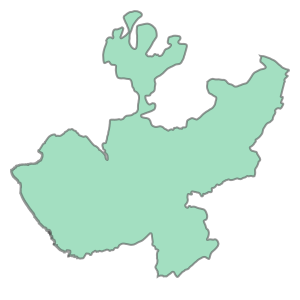

In [14]:
shape_Jalisco

In [69]:
def fun(id, path_fs):
    seg = PredictObject.objects.filter(id=id)
    path = seg[0].path
    shape_Jalisco_dc_tile = shape_Jalisco.intersection(shape(json.loads(seg[0].the_geom.geojson)))
    name_segmentation = path.split('/')[3].split('.')[0] + '_classified'
    with fiona.open(path) as src:
        source_driver = src.driver
        source_crs = src.crs
        source_schema = src.schema
        fc_pred = [(x[0]['geometry'], x[1].tag.numeric_code) for x in zip(src, pred_objects.filter(predict_object_id=id))]
        fc_schema = {'geometry': 'Polygon',
                     'properties': {'code': 'int'}}
        with fiona.open(path_fs + name_segmentation + '.shp',
                        'w',driver=source_driver, crs=source_crs,
                        schema=fc_schema) as dst:
            [dst.write({'geometry': mapping(shape(feat[0]).intersection(shape_Jalisco_dc_tile)),
                        'properties':{'code': feat[1]}}) for feat in fc_pred  if shape(feat[0]).intersects(shape_Jalisco_dc_tile)]
        
    return True

In [70]:
path_fs = '/shared_volume/tasks/2019/fiona_cloud_usage/moving_to_parallel_usage/'

In [71]:
scheduler_file= '/shared_volume/scheduler.json'

In [72]:
client = Client(scheduler_file=scheduler_file)

In [73]:
client

Client Scheduler: tcp://100.96.1.12:8786 Dashboard: http://100.96.1.12:8787/status,Cluster Workers: 2 Cores: 2 Memory: 16.00 GB


In [74]:
client.restart()

Client Scheduler: tcp://100.96.1.12:8786 Dashboard: http://100.96.1.12:8787/status,Cluster Workers: 2 Cores: 2 Memory: 16.00 GB


In [75]:
list_ids = [x.predict_object_id for x in qs_ids]

In [76]:
list_ids

[1, 2]

In [77]:
c = client.map(fun,list_ids,**{'path_fs': path_fs})

In [78]:
result = client.gather(c)

In [79]:
result

[True, True]